*<h3>Data Loading</h3>*

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


In [215]:
df = pd.read_csv('supermarket-sales.csv')
df1 = pd.read_csv('grocery_sales.csv')
df = pd.concat([df, df1], ignore_index=True)

*<h3>Data Cleaning and Preprocessing</h3>*
**1.Keeping Needed columns**

In [216]:
expected_cols = ['Order ID','Customer Name','Category','Subcategory','City','Orderdate','Region','Sales','Discount','Profit','State']
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df = df[expected_cols].copy()

**2.Parse Date robustly and Sales**

In [217]:
df['Orderdate'] = pd.to_datetime(df['Orderdate'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Orderdate', 'City', 'Sales'])
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df = df.dropna(subset=['Sales'])
display(df.head())

,Order ID,Customer Name,Category,Subcategory,City,Orderdate,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,2017-08-11,North,1254.0,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,2017-08-11,South,749.0,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,2017-12-06,West,2360.0,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,2016-11-10,South,896.0,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,2016-11-10,South,2355.0,0.26,918.45,Tamil Nadu


**3.Null_value_checking**

In [218]:
df.isna().sum()

Order ID         0
Customer Name    0
Category         0
Subcategory      0
City             0
Orderdate        0
Region           0
Sales            0
Discount         0
Profit           0
State            0
dtype: int64

**4. Aggregate to daily, per-city level**

In [219]:
daily = df.groupby(['City', pd.Grouper(key='Orderdate', freq='D')], as_index=False)['Sales'].sum()
daily = daily.rename(columns={'Orderdate':'date'}).sort_values(['City','date'])
print("Number of cities:", daily['City'].nunique())

Number of cities: 24


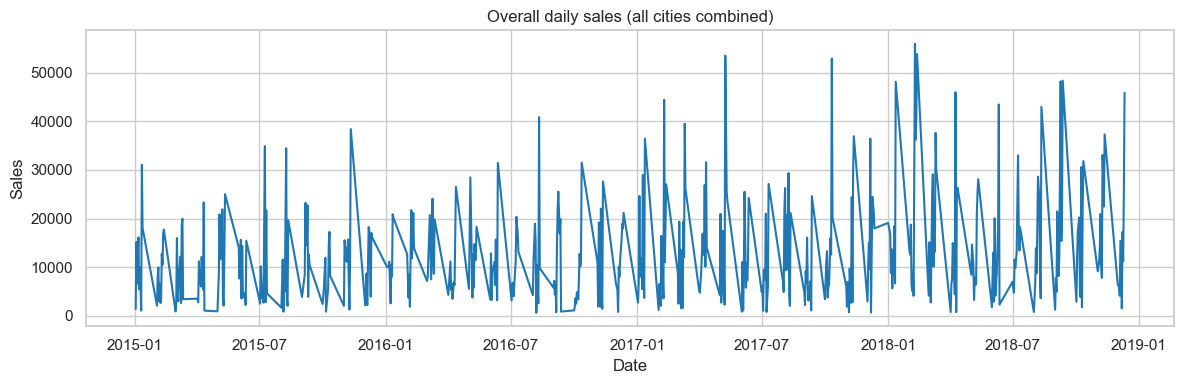

In [220]:
overall_daily = daily.groupby('date')['Sales'].sum().reset_index()

plt.figure(figsize=(12,4))
plt.plot(overall_daily['date'], overall_daily['Sales'], color='tab:blue')
plt.title('Overall daily sales (all cities combined)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

**5. Create features, lag & window**

In [221]:
def make_features(city_df):
    city_df = city_df.sort_values('date').set_index('date')
    city_df['year'] = city_df.index.year
    city_df['month'] = city_df.index.month
    city_df['day'] = city_df.index.day
    city_df['weekday'] = city_df.index.weekday
    city_df['is_weekend'] = city_df['weekday'].isin([5,6]).astype(int)
    
    for lag in [1,7,14,30]:
        city_df[f'lag_{lag}'] = city_df['Sales'].shift(lag)
    
    for window in [7,14,30]:
        city_df[f'roll_mean_{window}'] = city_df['Sales'].shift(1).rolling(window=window, min_periods=1).mean()
    
    city_df['sales_diff_1'] = city_df['Sales'] - city_df['lag_1']
    city_df['sales_pct_change_7'] = (city_df['Sales'] / city_df['lag_7'] - 1).replace([np.inf, -np.inf], np.nan)
    
    return city_df.reset_index()

**6. Apply features to all cities, drop initial NaNs, encode city**

In [222]:
frames = []
for city, grp in daily.groupby('City'):
    f = make_features(grp.copy())
    f['City'] = city
    frames.append(f)
all_df = pd.concat(frames, ignore_index=True)
all_df = all_df.dropna().reset_index(drop=True)

all_df['city_code'] = all_df['City'].astype('category').cat.codes
city_mean = all_df.groupby('City')['Sales'].mean().rename('city_mean_sales')
all_df = all_df.merge(city_mean, on='City', how='left')

feature_cols = [
    'city_code','city_mean_sales',
    'year','month','day','weekday','is_weekend',
    'lag_1','lag_7','lag_14','lag_30',
    'roll_mean_7','roll_mean_14','roll_mean_30',
    'sales_diff_1','sales_pct_change_7'
]
feature_cols = [c for c in feature_cols if c in all_df.columns]

*<h3>Visualizing</h3>*

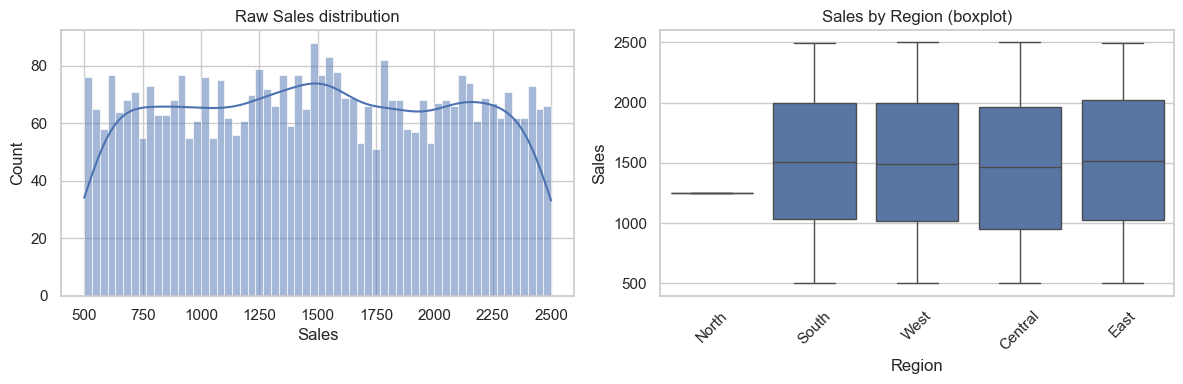

In [223]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['Sales'], bins=60, kde=True)
plt.title('Raw Sales distribution')

plt.subplot(1,2,2)
sns.boxplot(x='Region', y='Sales', data=df)
plt.title('Sales by Region (boxplot)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

,date,City,Sales,year,month,day,weekday,is_weekend,lag_1,lag_7,lag_14,lag_30,roll_mean_7,roll_mean_14,roll_mean_30,sales_diff_1,sales_pct_change_7
0,2015-01-08,Vellore,2337.0,2015,1,8,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-11,Vellore,5215.0,2015,1,11,6,1,2337.0,NaN,NaN,NaN,2337.000000,2337.000000,2337.000000,2878.0,NaN
2,2015-02-02,Vellore,525.0,2015,2,2,0,0,5215.0,NaN,NaN,NaN,3776.000000,3776.000000,3776.000000,-4690.0,NaN
3,2015-02-04,Vellore,1134.0,2015,2,4,2,0,525.0,NaN,NaN,NaN,2692.333333,2692.333333,2692.333333,609.0,NaN
4,2015-02-06,Vellore,3179.0,2015,2,6,4,0,1134.0,NaN,NaN,NaN,2302.750000,2302.750000,2302.750000,2045.0,NaN
5,2015-02-10,Vellore,3623.0,2015,2,10,1,0,3179.0,NaN,NaN,NaN,2478.000000,2478.000000,2478.000000,444.0,NaN
6,2015-02-12,Vellore,1419.0,2015,2,12,3,0,3623.0,NaN,NaN,NaN,2668.833333,2668.833333,2668.833333,-2204.0,NaN
7,2015-03-10,Vellore,1975.0,2015,3,10,1,0,1419.0,2337.0,NaN,NaN,2490.285714,2490.285714,2490.285714,556.0,-0.154899
8,2015-04-04,Vellore,3001.0,2015,4,4,5,1,1975.0,5215.0,NaN,NaN,2438.571429,2425.875000,2425.875000,1026.0,-0.424545
9,2015-04-10,Vellore,842.0,2015,4,10,4,0,3001.0,525.0,NaN,NaN,2122.285714,2489.777778,2489.777778,-2159.0,0.603810


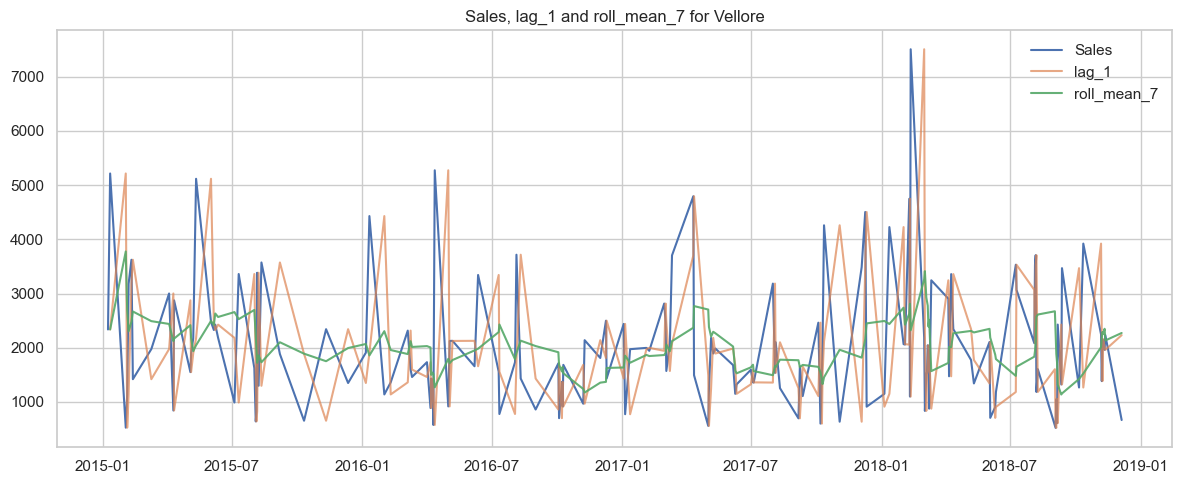

In [224]:
sample_city = daily['City'].value_counts().idxmax()
sample_df = daily[daily['City']==sample_city].copy()
feat_sample = make_features(sample_df)
display(feat_sample.head(12))
plt.figure(figsize=(12,5))
plt.plot(feat_sample['date'], feat_sample['Sales'], label='Sales')
plt.plot(feat_sample['date'], feat_sample['lag_1'], label='lag_1', alpha=0.7)
plt.plot(feat_sample['date'], feat_sample['roll_mean_7'], label='roll_mean_7', alpha=0.9)
plt.title(f'Sales, lag_1 and roll_mean_7 for {sample_city}')
plt.legend()
plt.tight_layout()
plt.show()

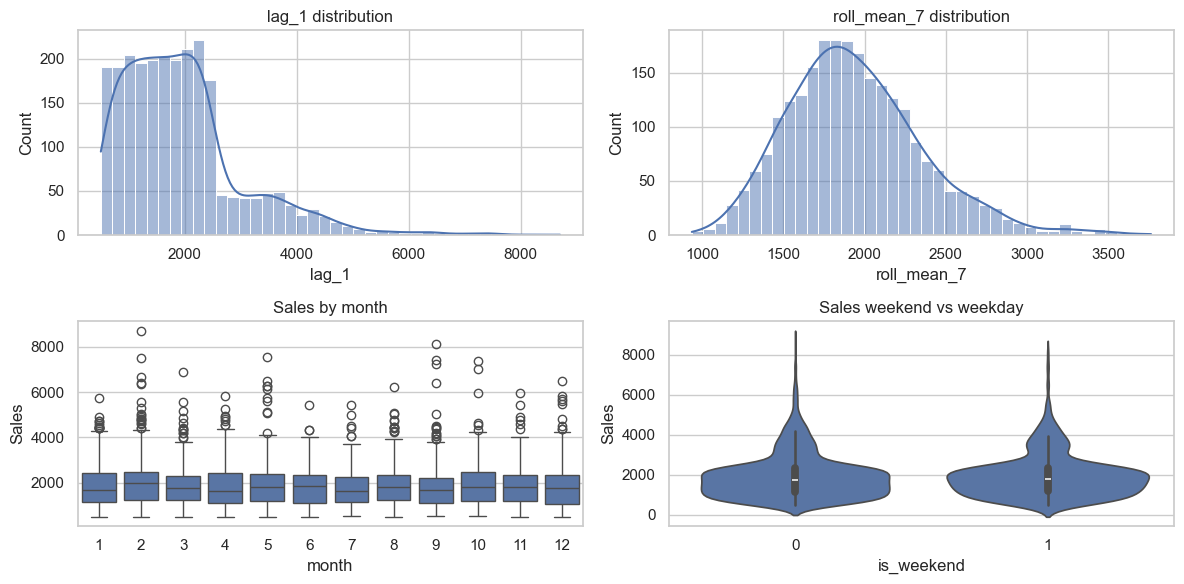

In [225]:
# Visual: distributions of some engineered features
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
sns.histplot(all_df['lag_1'], bins=40, kde=True)
plt.title('lag_1 distribution')

plt.subplot(2,2,2)
sns.histplot(all_df['roll_mean_7'], bins=40, kde=True)
plt.title('roll_mean_7 distribution')

plt.subplot(2,2,3)
sns.boxplot(x='month', y='Sales', data=all_df)
plt.title('Sales by month')

plt.subplot(2,2,4)
sns.violinplot(x='is_weekend', y='Sales', data=all_df)
plt.title('Sales weekend vs weekday')
plt.tight_layout()
plt.show()

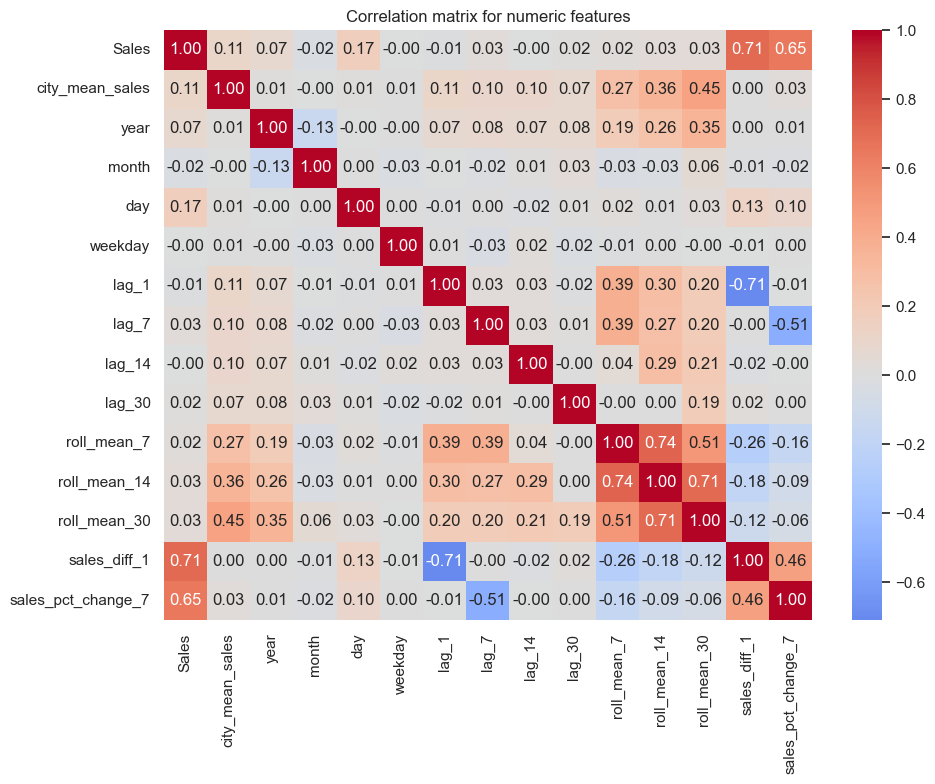

In [226]:
numeric_subset = all_df[['Sales'] + [c for c in feature_cols if c not in ['city_code','is_weekend']]]
corr = numeric_subset.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation matrix for numeric features')
plt.tight_layout()
plt.show()

*<h3>Manual spliting and Scaling</h3>*

In [227]:
X = all_df[feature_cols].copy()
y = np.log1p(all_df['Sales'])

all_df['date'] = pd.to_datetime(all_df['date'])
unique_dates = np.sort(all_df['date'].unique())
split_idx = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_idx]
test_dates = unique_dates[split_idx:]


In [228]:
train_mask = all_df['date'].isin(train_dates)
X_train, X_test = X[train_mask].reset_index(drop=True), X[~train_mask].reset_index(drop=True)
y_train, y_test = y[train_mask].reset_index(drop=True), y[~train_mask].reset_index(drop=True)

print("Train date range:", train_dates.min(), "to", train_dates.max())
print("Test date range:", test_dates.min(), "to", test_dates.max())

Train date range: 2015-08-10T00:00:00.000000000 to 2018-05-09T00:00:00.000000000
Test date range: 2018-05-10T00:00:00.000000000 to 2018-12-11T00:00:00.000000000


**7. Scale numeric features and visualize before/after**

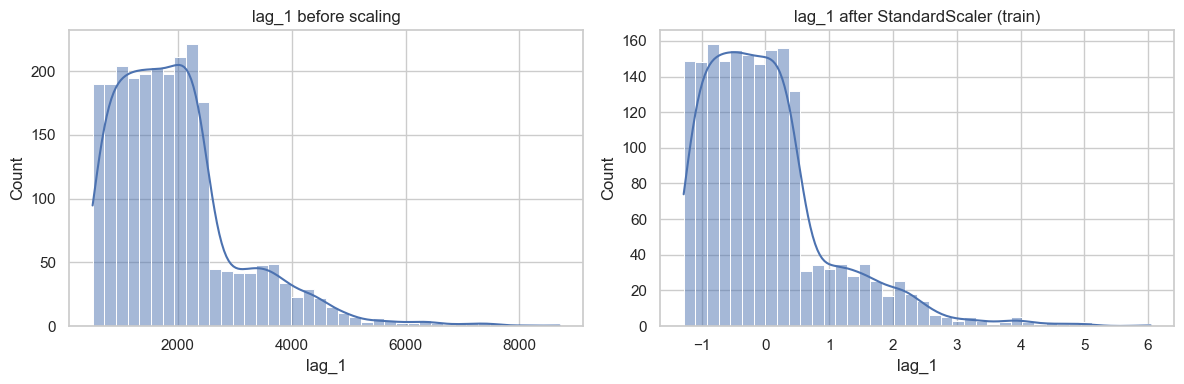

In [229]:
num_feats = ['city_mean_sales','year','month','day','weekday','lag_1','lag_7','lag_14','lag_30','roll_mean_7','roll_mean_14','roll_mean_30','sales_diff_1','sales_pct_change_7']
num_feats = [c for c in num_feats if c in X_train.columns]

scaler = StandardScaler()
X_train[num_feats] = scaler.fit_transform(X_train[num_feats])
X_test[num_feats] = scaler.transform(X_test[num_feats])

unscaled = all_df[feature_cols].copy()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(unscaled['lag_1'].dropna(), bins=40, kde=True)
plt.title('lag_1 before scaling')
plt.subplot(1,2,2)
sns.histplot(X_train['lag_1'].dropna(), bins=40, kde=True)
plt.title('lag_1 after StandardScaler (train)')
plt.tight_layout()
plt.show()

*<h3>Deciding param_grid & Training:</h3>Grid search RandomForest*

In [230]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


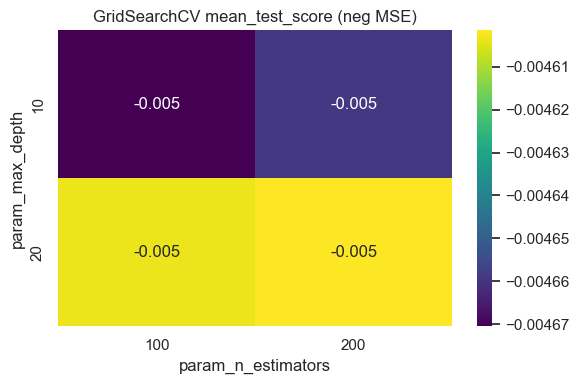

In [231]:
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

# Visual: CV performance heatmap (mean test score)
results = pd.DataFrame(grid_search.cv_results_)
pivot = results.pivot_table(values='mean_test_score',
                            index='param_max_depth',
                            columns='param_n_estimators')
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
plt.title('GridSearchCV mean_test_score (neg MSE)')
plt.tight_layout()
plt.show()

*<h3>Evaluate on test set</h3>*

In [232]:
y_pred_log = best_model.predict(X_test)
y_pred_final = np.expm1(y_pred_log)
y_test_final = np.expm1(y_test)

mae = mean_absolute_error(y_test_final, y_pred_final)
mse = mean_squared_error(y_test_final, y_pred_final)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_final, y_pred_final)
mape = np.mean(np.abs((y_test_final - y_pred_final) / np.where(y_test_final==0, 1e-8, y_test_final))) * 100
accuracy = 100 - mape

In [233]:
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom[denom==0] = 1e-8
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denom)

smape_score = smape(y_test_final, y_pred_final)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")
print(f"SMAPE: {smape_score:.2f}%")

MAE: 63.52
MSE: 22952.84
RMSE: 151.50
R²: 0.980
MAPE: 2.98%
Accuracy: 97.02%
SMAPE: 3.02%


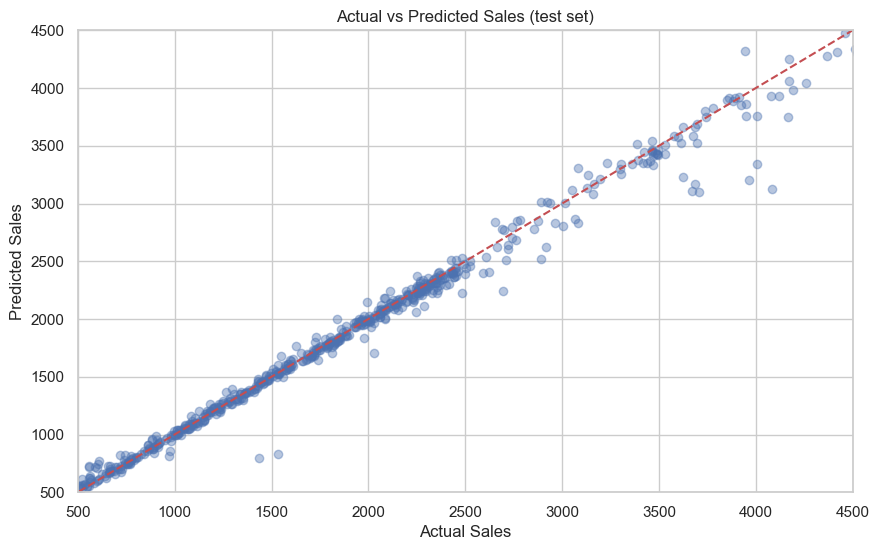

In [234]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_final, y_pred_final, alpha=0.4)
lims = (min(y_test_final.min(), y_pred_final.min()), max(y_test_final.max(), y_pred_final.max()))
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (test set)')


plt.xlim(500, 4500)
plt.ylim(500, 4500)

plt.show()

**8. Feature importances visualization**

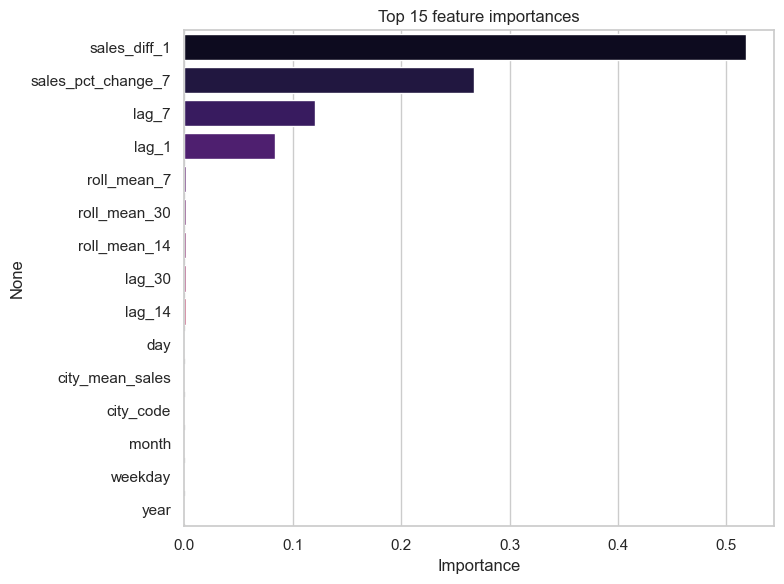

In [235]:
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.head(15).values, y=feat_imp.head(15).index, palette='magma')
plt.title('Top 15 feature importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

**9. Persist Model, Scalar, Meta**

In [210]:
import pickle
import os

MODEL_DIR = r'C:\Users\UsamaDuldule\Desktop\usaid\Indian_Grocery_Products_Sales_prediction_Randomforest'
MODEL_BASENAME = 'sales_model_v2'
MODEL_FILE = os.path.join(MODEL_DIR, MODEL_BASENAME + '.joblib')
META_FILE = os.path.join(MODEL_DIR, MODEL_BASENAME + '_meta.pkl')

os.makedirs(MODEL_DIR, exist_ok=True)
joblib.dump(best_model, MODEL_FILE)

meta = {
    'feature_columns': feature_cols,
    'num_features': num_feats,
    'city_categories': list(all_df['City'].astype('category').cat.categories)
}
with open(META_FILE, 'wb') as f:
    pickle.dump(meta, f)

print(f"Saved model to {MODEL_FILE}")
print(f"Saved meta to {META_FILE}")

Saved model to C:\Users\UsamaDuldule\Desktop\usaid\Indian_Grocery_Products_Sales_prediction_Randomforest\sales_model_v2.joblib
Saved meta to C:\Users\UsamaDuldule\Desktop\usaid\Indian_Grocery_Products_Sales_prediction_Randomforest\sales_model_v2_meta.pkl


Linear (Ridge) Regression metrics
MAE: 347.66
RMSE: 1312.30
R2: -0.466
MAPE: 15.59%
SMAPE: 14.29%
Accuracy: 84.41%


(0.0, 7000.0)

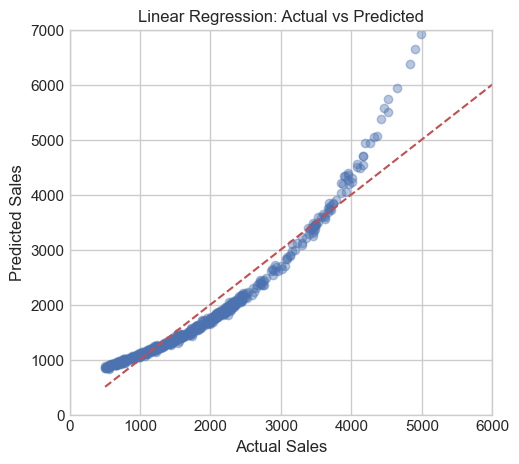

In [207]:
# Cell: Linear Regression training, evaluation, and visuals
# Requires: X_train, X_test, y_train, y_test, scaler (if used), feature_cols (or feature_columns), num_feats
from sklearn.linear_model import Ridge

# Use Ridge (regularized linear) for better stability than plain LinearRegression
lr = Ridge(alpha=1.0, random_state=42)
lr.fit(X_train, y_train)

# Predict and invert log transform
y_pred_log_lr = lr.predict(X_test)
y_pred_lr = np.expm1(y_pred_log_lr)
y_true_lr = np.expm1(y_test)

# Metrics
mae_lr = mean_absolute_error(y_true_lr, y_pred_lr)
mse_lr = mean_squared_error(y_true_lr, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_true_lr, y_pred_lr)
mape_lr = np.mean(np.abs((y_true_lr - y_pred_lr) / np.where(y_true_lr==0, 1e-8, y_true_lr))) * 100

def smape(a,b):
    denom = (np.abs(a) + np.abs(b))
    denom[denom==0] = 1e-8
    return 100 * np.mean(2 * np.abs(b - a) / denom)

smape_lr = smape(y_true_lr, y_pred_lr)
accuracy_lr = 100 - mape_lr

print("Linear (Ridge) Regression metrics")
print(f"MAE: {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R2: {r2_lr:.3f}")
print(f"MAPE: {mape_lr:.2f}%")
print(f"SMAPE: {smape_lr:.2f}%")
print(f"Accuracy: {accuracy_lr:.2f}%")

# Visuals: Actual vs Predicted and Residuals
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_true_lr, y_pred_lr, alpha=0.4)
lims = (min(y_true_lr.min(), y_pred_lr.min()), max(y_true_lr.max(), y_pred_lr.max()))
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlim(0, 6000)
plt.ylim(0, 7000)


--------------------------------------------------
MAE: 66.46
RMSE: 136.33
R2: 0.984
SMAPE: 3.42%
MAPE: 3.41%
Accuracy: 96.59%
Best iteration used: 794
--------------------------------------------------


(0.0, 6000.0)

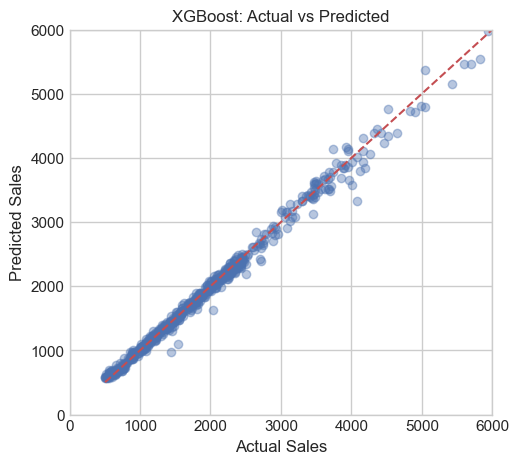

In [208]:
# XGBoost using DMatrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


val_size = max(1, int(len(X_train) * 0.1))
X_tr = X_train.iloc[:-val_size].copy()
y_tr = y_train.iloc[:-val_size].copy()
X_val = X_train.iloc[-val_size:].copy()
y_val = y_train.iloc[-val_size:].copy()

# Ensure numeric and drop/replace NaNs (should not drop rows in train/val; fail early if present)
def ensure_numeric_no_nans(df, name):
    if df.isnull().any().any():
        
        df = df.fillna(df.mean()) 
    # convert to float32 numpy
    return np.asarray(df).astype(np.float32)

try:
    X_tr_np = ensure_numeric_no_nans(X_tr, "X_tr")
    X_val_np = ensure_numeric_no_nans(X_val, "X_val")
    X_test_np = ensure_numeric_no_nans(X_test, "X_test")
except NameError:
     print("Error: X_train, y_train, or X_test are not defined. Run the full data aggregation script first.")
     raise

y_tr_np = np.asarray(y_tr).astype(np.float32).ravel()
y_val_np = np.asarray(y_val).astype(np.float32).ravel()
y_test_np = np.asarray(y_test).astype(np.float32).ravel()


dtrain = xgb.DMatrix(X_tr_np, label=y_tr_np)
dval = xgb.DMatrix(X_val_np, label=y_val_np)
dtest = xgb.DMatrix(X_test_np, label=y_test_np)


params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'seed': 42,
    'verbosity': 0
}
num_boost_round = 1000
early_stopping_rounds = 50

evallist = [(dtrain, 'train'), (dval, 'valid')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evallist,
    early_stopping_rounds=early_stopping_rounds, 
    verbose_eval=False
)

y_pred_log = bst.predict(dtest, iteration_range=(0, bst.best_iteration))
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_np)


mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

def smape(a, b):
    denom = (np.abs(a) + np.abs(b))
    denom[denom==0] = 1e-8 
    return 100 * np.mean(2 * np.abs(b - a) / denom)

smape_score = smape(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-8, y_true))) * 100
accuracy = 100 - mape

print("--------------------------------------------------")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.3f}")
print(f"SMAPE: {smape_score:.2f}%")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Best iteration used: {bst.best_iteration}")
print("--------------------------------------------------")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_true, y_pred, alpha=0.4)
lims = (min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max()))
plt.plot(lims, lims, 'r--'); plt.xlabel('Actual Sales'); plt.ylabel('Predicted Sales'); plt.title('XGBoost: Actual vs Predicted')
plt.xlim(0, 6000)
plt.ylim(0, 6000)